In [1]:
%load_ext autoreload
%autoreload 2
from vip_helpers import *
from state.extractStates import *
from utils.alignmentFunctions import *

vip_data = load_vip_data()
dataclasses, state_dfs, s2p_outs, recordings = load_data_for_day('p17')
spikes = [s2p_out.get_cell_spikes() for s2p_out in s2p_outs]

Getting data for p17


### Facial motion vs correlation bar

In [ ]:
days = vip_data['day'].to_numpy()
for day in days:
    plot_correlation_hist_vip(day, plot_title='Facial motion vs Spiking correlation')

In [14]:
import os
import numpy as np
from intan.readIntan import *
from utils.filtering import *

try:
    import cupy as cp
    GPU_AVAILABLE = True
    print('GPU available!')
except Exception:
    GPU_AVAILABLE = False
    print('GPU unavailable. Using CPU fallback')

def extract_lfp_preallocated_2chan(
    basepath,
    channels,                         # <- list/array of 0-based channel indices
    out_fs=1250,
    lopass=450.0,
    output_lfppath=None,
    csv_savepath=None,
    return_data=True,
    chunk_frames=2_000_000,           # <- input timepoints per chunk
    dtype=np.int16,
    raw_matrix=None                   # <- OPTIONAL: memmap or ndarray (num_timepoints, num_channels)
):
    """
    Extract LFP from an interleaved Intan analog file by streaming time chunks
    and selecting only the requested `channels`.

    If `raw_matrix` is provided (shape: [num_timepoints, num_channels]), it is
    used directly; otherwise the function memmaps the Intan file.

    Output .lfp is int16 with shape (out_frames, n_selected_channels).
    Optionally returns float32 data (n_selected_channels, out_frames).
    """

    # You already have this helper:
    amp_analog_aux_in, intan_header, time_file = get_intan_files(basepath)
    basename = os.path.basename(basepath)

    # ---- Output paths ----
    if output_lfppath is None:
        lfp_out = os.path.join(basepath, f"{basename}.lfp")
    else:
        lfp_out = output_lfppath if output_lfppath.endswith(".lfp") else output_lfppath + ".lfp"
    if csv_savepath is not None and not csv_savepath.endswith(".csv"):
        csv_savepath += ".csv"

    # ---- Header / sizes ----
    in_fs = int(intan_header['sample_rate'])
    total_channels = (intan_header['num_amplifier_channels']
                      + intan_header['num_board_adc_channels']
                      + intan_header['num_aux_input_channels'])

    # Channels validation
    channels = np.asarray(channels, dtype=int)
    if channels.ndim != 1 or channels.size == 0:
        raise ValueError("`channels` must be a non-empty 1D list/array.")
    if (channels < 0).any() or (channels >= total_channels).any():
        raise ValueError(f"Channel indices must be within [0, {total_channels-1}].")

    # Decimation ratio
    if in_fs % out_fs != 0:
        raise ValueError(f"in_fs ({in_fs}) must be an integer multiple of out_fs ({out_fs}).")
    sample_ratio = in_fs // out_fs

    # Lopass sanity (keep margin below out Nyquist)
    nyq_out = 0.5 * out_fs
    if lopass >= 0.9 * nyq_out:
        lopass = 0.9 * nyq_out
        print(f"[note] lopass adjusted to {lopass:.1f} Hz (< 0.9 * {nyq_out:.1f} Nyq).")

    # Determine number of timepoints at input
    if raw_matrix is not None:
        if raw_matrix.ndim != 2 or raw_matrix.shape[1] != total_channels:
            raise ValueError("`raw_matrix` must be (num_timepoints, total_channels).")
        num_timepoints = raw_matrix.shape[0]
        src = raw_matrix
        use_memmap_file = False
    else:
        # Compute number of interleaved frames from the file size
        bytes_per_sample = np.dtype(dtype).itemsize
        fsize = os.path.getsize(amp_analog_aux_in)
        num_timepoints = fsize // (bytes_per_sample * total_channels)
        # Memmap *as 2-D* (time, channels) so slicing src[start:stop, channels] is natural
        src = np.memmap(
            amp_analog_aux_in, dtype=dtype, mode='r',
            shape=(num_timepoints, total_channels)
        )
        use_memmap_file = True

    # Output time length (ceil)
    out_frames = (num_timepoints + sample_ratio - 1) // sample_ratio
    n_sel = channels.size

    # Align chunk to decimation ratio so strides are clean
    if chunk_frames % sample_ratio != 0:
        chunk_frames += sample_ratio - (chunk_frames % sample_ratio)

    # Prepare output memmap: (out_frames, n_sel)
    lfp_out_map = np.memmap(lfp_out, dtype=np.int16, mode="w+", shape=(out_frames, n_sel))

    # --- Your lowpass (expects [channels, samples]); keep the same function you already use ---
    def _lp(data_cs):
        # Replace with your implementation if different
        return sinc_lowpass_filter(data_cs, cutoff=lopass, fs=in_fs)

    out_pointer = 0
    float_chunks = [] if return_data else None

    # Number of batches (ceil)
    n_batches = (num_timepoints + chunk_frames - 1) // chunk_frames
    print(f"Processing {'memmap file' if use_memmap_file else 'raw_matrix'} in {n_batches} batches...")

    start = 0
    while start < num_timepoints:
        stop = min(start + chunk_frames, num_timepoints)

        # ---- Read ONLY requested columns for this time window ----
        # src[start:stop, channels] produces a small (stop-start, n_sel) array
        block_sel_tc = src[start:stop, channels]  # (time, n_sel), dtype int16 (or whatever dtype)
        if block_sel_tc.size == 0:
            break

        # To filter, move to (channels, samples) and float32
        block_sel_cs = block_sel_tc.T.astype(np.float32, copy=False)  # (n_sel, samples_in_chunk)

        # Filter → decimate
        filt_cs = _lp(block_sel_cs)                 # (n_sel, samples_in_chunk)
        down_cs = filt_cs[:, ::sample_ratio]        # (n_sel, samples_out_chunk)

        # Write to disk as int16
        if GPU_AVAILABLE:
            down_int = cp.asnumpy(cp.around(cp.asarray(down_cs)).astype(np.int16))
            down_f32 = cp.asnumpy(cp.asarray(down_cs, dtype=cp.float32)) if return_data else None
        else:
            down_int = np.around(down_cs).astype(np.int16)
            down_f32 = down_cs if return_data else None

        n_out = down_int.shape[1]
        lfp_out_map[out_pointer:out_pointer + n_out, :] = down_int.T  # map is (time, n_sel)
        out_pointer += n_out

        if return_data:
            float_chunks.append(down_f32)

        start = stop

    # Flush output
    lfp_out_map.flush()
    print(f"LFP extraction complete. Saved to: {lfp_out}")

    if return_data:
        final_data = np.hstack(float_chunks)  # (n_sel, out_frames)
        if csv_savepath is not None:
            np.savetxt(csv_savepath, final_data.T, delimiter=",", fmt="%.4f")
        return final_data
    else:
        if csv_savepath is not None:
            print("[note] csv_savepath ignored because return_data=False.")
        return None


#test_path = '/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p9'
basepaths = pd.read_parquet('basepaths.parquet')['paths']
for test_path in basepaths:
    print(f'Extracting lfp for {test_path}')
    try:
        extract_lfp_preallocated_2chan(test_path, channels=[1,2], return_data=True,
                                    output_lfppath=os.path.join(
                                        test_path, os.path.basename(test_path) + '.lfp'))
    except:
        try:
            test_path = os.path.join(test_path, 'spon')
            extract_lfp_preallocated_2chan(test_path, channels=[1,2], return_data=True,
                                    output_lfppath=os.path.join(
                                        test_path, os.path.basename(test_path) + '.lfp'))
        except: 
            traceback.print_exc()
            continue

    
    #csv_savepath='outputs/lfp_test', output_lfppath)

GPU available!
Extracting lfp for /mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p9

Reading Intan Technologies RHD Data File, Version 1.5

Found 3 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 2 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Processing memmap file in 13 batches...
LFP extraction complete. Saved to: /mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p9/p9.lfp
Extracting lfp for /mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p10

Reading Intan Technologies RHD Data File, Version 1.5

Found 3 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 3 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Processing memmap file in

In [ ]:
from utils.lfpFunctions import *
from utils.plotLFP import *

import matplotlib.pyplot as plt
lfp = 
f, t, Sdb = compute_spectrogram_db(lfp, fs_hz=1250, nperseg=2048, max_freq_hz=200)
plt.figure(figsize=(10,4))
plt.pcolormesh(t, f, Sdb, shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('LFP Spectrogram (0–200 Hz)')
cbar = plt.colorbar()
cbar.set_label('Power (dB)')
plt.ylim(0, 200)  # extra guard in case you omit max_freq_hz
plt.tight_layout()
plt.show()


### Spike triggered average motion

In [ ]:
plot_spike_ta_vip('p17')

In [15]:
days = vip_data['day']
# # before the loop
population_spikes_restricted = pd.DataFrame()

for day_idx, day in enumerate(days):
    dataclasses, state_dfs, s2p_outs, recordings = load_data_for_day(day)
    #pop_spikes = [s2p_out.get_cell_spikes() for s2p_out in s2p_outs]
    aligned_dfs = [dataclasses[rec_idx].make_aligned_frame_df(state_dfs[rec_idx]) for rec_idx in range(len(s2p_outs))]
    motion = [aligned_dfs[rec_idx]['motion'] for rec_idx in range(len(s2p_outs))]
    motion_z = zscore_robust(restrict_traces(motion))
    # spikes_z = restrict_traces(pop_spikes)  # shape: (n_cells_total, T_common)
    # spikes_z = zscore_robust(spikes_z)
    # # 1) make a DF with unique column names
    # T = spikes_z.shape[1]
    #df_spk = pd.DataFrame(spikes_z, columns=[f"t{j}" for j in range(T)])
    df_spk = pd.DataFrame(motion_z)
    # # 2) add metadata columns (length must match n_rows = n_cells_total)
    df_spk.insert(0, "day", day)  # or day_idx
    # # optional: keep a per-row cell index
    # df_spk.insert(1, "cell_idx", np.arange(spikes_z.shape[0], dtype=int))

    # 3) stack rows safely
    population_spikes_restricted = pd.concat(
        [population_spikes_restricted, df_spk],
        axis=0, ignore_index=True
    )

# save
population_spikes_restricted.to_parquet("outputs/pop_motion_z_restricted.parquet")

Getting data for p9
Getting data for p10
Getting data for p12
Getting data for p13
Getting data for p14
Getting data for p15
Getting data for p16
Getting data for p17
Getting data for p19


/home/gianna/anaconda3/envs/vip_venv/lib/python3.10/site-packages/pandas/io/parquet.py:191: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Getting data for p9
Getting data for p10
Getting data for p12
Getting data for p13
Getting data for p14
Getting data for p15
Getting data for p16
Getting data for p17
Getting data for p19


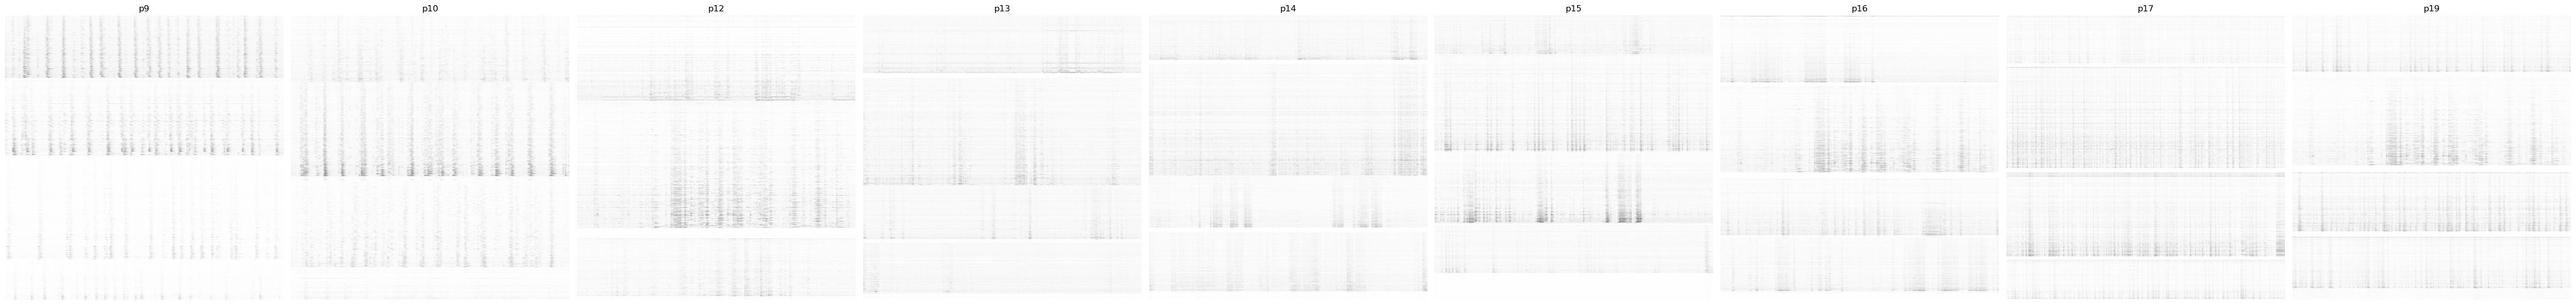

In [ ]:
from utils.alignmentFunctions import stack_traces, restrict_traces
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import Normalize
from vip_helpers import *
from utils.stats import zscore_robust

vip_data = load_vip_data()
days = vip_data['day'].to_numpy()
fig, axs = plt.subplots(1, len(days), figsize=(50, 6))
for day_idx, day in enumerate(days):
    dataclasses, state_dfs, s2p_outs, recordings = load_data_for_day(day)
    pop_spikes = [s2p_out.get_cell_spikes() for s2p_out in s2p_outs]
    # stack → z-score (you already do these)
    spikes_z = restrict_traces(pop_spikes)        # (n_cells_total, T_common)
    spks_z    = zscore_robust(spikes_z, axis=1)   # column-wise z

    # robust display range from the *stacked* array
    vmin = np.nanpercentile(spks_z, 1)
    vmax = np.nanpercentile(spks_z, 99)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
        # fallback to safe defaults if array is constant/NaN
        vmin, vmax = -1.0, 1.0

    norm = Normalize(vmin=vmin, vmax=vmax)

    axs[day_idx].imshow(spks_z, aspect='auto', cmap='binary',
                        origin='lower', norm=norm)
    axs[day_idx].set_title(day)
    axs[day_idx].axis('off')
    # Remove x-axis ticks and labels
    axs[day_idx].xaxis.set_major_locator(mticker.NullLocator())
    axs[day_idx].xaxis.set_major_formatter(mticker.NullFormatter())

    # Remove y-axis ticks and labels
    axs[day_idx].yaxis.set_major_locator(mticker.NullLocator())
    axs[day_idx].yaxis.set_major_formatter(mticker.NullFormatter())
plt.tight_layout()
plt.show()

### Plot state timeline

In [ ]:
from scipy.stats import mode
from utils.alignmentFunctions import restrict_traces
vip_data = load_vip_data()
def most_common(arr):
    modes = []
    for col in arr.T:
        vals, counts = np.unique(col, return_counts=True)
        modes.append(vals[counts.argmax()])
    return np.array(modes, dtype=object)
days = vip_data['day'].to_numpy()
#days = ['p19']
fig, axs = plt.subplots(2, len(days), figsize=(80,10))
axs_idx = 0
for day_idx, day in enumerate(days):
    dataclasses, state_dfs, s2p_outs, recordings = load_data_for_day(day)
    pop_spikes = [s2p_out.get_cell_spikes() for s2p_out in s2p_outs]
    pop_spikes = restrict_traces(pop_spikes)[:, :-1]
    aligned_dfs = [dataclasses[rec_idx].make_aligned_frame_df(state_dfs[rec_idx]) for rec_idx in range(len(s2p_outs))]
    frame_times = restrict_traces([aligned_df['frame_time'] for aligned_df in aligned_dfs])
    motion_2p = restrict_traces([aligned_df['motion'] for aligned_df in aligned_dfs])
    states = restrict_traces([aligned_df['state'] for aligned_df in aligned_dfs])
    most_common_state = most_common(states)
    from state.extractStates import plot_state_timeline_vip
    ft = np.nanmedian(frame_times, axis=0)
    motion, spikes =  np.nanmean(motion_2p, axis=0), np.nanmean(pop_spikes, axis=0)
    plot_state_timeline_vip(
        pd.DataFrame({'time': ft,'state':most_common_state}), 
        motion, spikes, title = day)

In [ ]:
r = cell_motion_correlations(spikes_z, motion_z)   # r shape = (n_cells,)
